**Pytorch BERT baseline**

In this version, I convert https://www.kaggle.com/akensert/bert-base-tf2-0-minimalistic into pytorch version

**Please upvote the kernel if you find it helpful**

As we are not allowed to use internet I've created required datasets and commands to setup Hugging Face Transformers setup in offline mode. You can find the required github codebases in the datasets.

* sacremoses dependency - https://www.kaggle.com/axel81/sacremoses
* transformers - https://www.kaggle.com/axel81/transformers

In [1]:
import random
import re
import pandas as pd
from nltk import sent_tokenize
from tqdm import tqdm
from albumentations.core.transforms_interface import DualTransform, BasicTransform

In [2]:
# !pip install ./sacremoses/sacremoses-master/
# !pip install ./transformers/transformers-master/

STRIDE = 1
def is_jupyter():
    try:
        ipy_str = str(type(get_ipython()))
        if 'zmqshell' in ipy_str:
            return True
        
    except:
        return False

### Required Imports

I've added imports that will be used in training too

In [3]:
from sklearn.model_selection import train_test_split
import re
from random import shuffle as shfl
from auc import MyAUCCallback
from sklearn.utils import shuffle
from datetime import datetime
import pandas as pd
pd.set_option('display.max.columns', 500)
import numpy as np
import os
#os.environ['CUDA_VISIBLE_DEVICES'] ='3'
# os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-10.1/lib64'
import matplotlib.pyplot as plt
import gc
from shutil import copyfile
from catalyst.dl import SupervisedRunner, AlchemyLogger, CriterionCallback
from catalyst.dl.callbacks.metrics import AUCCallback
from torch.utils.data import DataLoader, SubsetRandomSampler,Dataset
batch_size =32
token = "d1dd16f08d518293bcbeddd313b49aa4"
DATA_DIR = '/kaggle/input/jigsaw-multilingual-toxic-comment-classification/'

/home/kb/jig_env/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/kb/jig_env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/home/kb/jig_env/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [4]:
if os.uname()[1] == 'kb-Z370P-D3':
    # desktop
    LOG_PATH = '/media/ssd/logs/jigsaw'
    SERVER = False
    print('Working on desktop')
elif os.uname()[1] == 'kb-server':
    # server
    LOG_PATH = '/home/kb/logs/jigsaw'
    SERVER = True
    print('Working on server')
else:
    raise Exception('which hostname???')
    

Working on desktop


In [5]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

df_valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [6]:
# Combine train1 with a subset of train2
df_train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

In [7]:
df_train['lang']='en'

In [8]:
df_test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')

In [9]:
# df_pseudo = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/pseudo_labelling_09459.csv')
df_pseudo = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/pseudo_labelling_09393.csv')
df_pseudo.head()

,id,toxic
0,0,0.000060
1,1,0.000020
2,2,0.173887
3,3,0.000015
4,4,0.000019


In [10]:
df_pseudo2 = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/pseudo_labelling_09459.csv')
df_pseudo2.head()

,id,toxic
0,0,0.004235
1,1,0.020938
2,2,0.269427
3,3,0.008064
4,4,0.007442


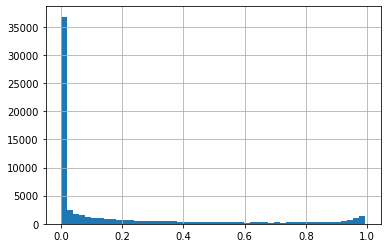

In [11]:
df_pseudo.toxic.hist(bins=50)

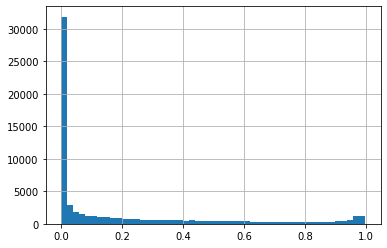

In [12]:
df_pseudo2.toxic.hist(bins=50)

In [13]:
df_pseudo = df_pseudo.merge(df_pseudo2, on='id')
df_pseudo.head()

,id,toxic_x,toxic_y
0,0,0.000060,0.004235
1,1,0.000020,0.020938
2,2,0.173887,0.269427
3,3,0.000015,0.008064
4,4,0.000019,0.007442


In [14]:
df_pseudo = df_pseudo[((df_pseudo['toxic_x']>0.9) & (df_pseudo['toxic_y']>0.9)) | ((df_pseudo['toxic_x']<0.1) & (df_pseudo['toxic_y']<0.1))]
df_pseudo['toxic'] = (df_pseudo['toxic_y'] + df_pseudo['toxic_x'])/2
df_pseudo = df_pseudo[['id', 'toxic']]

In [15]:
# df_pseudo = df_pseudo[(df_pseudo['toxic']>0.9) | (df_pseudo['toxic']<0.1)]

In [16]:
df_pseudo.loc[df_pseudo['toxic']>0.5, 'toxic'] = 1.0
df_pseudo.loc[df_pseudo['toxic']<=0.5, 'toxic'] = 0.0

In [17]:
len(df_pseudo)

42421

In [18]:
df_pseudo = df_pseudo.merge(df_test, on='id').rename(columns={'content':'comment_text'})
df_pseudo.head()

,id,toxic,comment_text,lang
0,0,0.0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,0.0,"Вполне возможно, но я пока не вижу необходимо...",ru
2,3,0.0,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
3,4,0.0,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr
4,5,0.0,Le truc le plus important dans ta tirade c est...,fr


In [19]:
df_valid.head()

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


In [20]:
df_my_back_trans = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/toxic_pt0_all_lng.csv')


In [21]:
df_my_back_trans.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0000997932d777bf,0,0,0,0,0,0,açıklama\nNeden kullanıcı adım Hardcore Metall...
1,000103f0d9cfb60f,0,0,0,0,0,0,D'aww! O görünüşte ile sıkışmış ediyorum bu ar...
2,000113f07ec002fd,0,0,0,0,0,0,"Hey dostum, gerçekten düzenleme savaşa çalışmı..."
3,0001b41b1c6bb37e,0,0,0,0,0,0,"""\nDaha\nbölüm istatistikleri sonradan olmalı ..."
4,0001d958c54c6e35,0,0,0,0,0,0,"Sen, benim kahraman efendim. Herhangi bir şans..."


In [22]:
df_my_back_trans['lang']='unknown'

In [23]:

df_train = df_train\
    .append(df_my_back_trans[df_train.columns])\
    .append(df_pseudo[df_train.columns])\
    .reset_index(drop=True)
df_train.head()
# df_valid_sp = df_valid_sp.reset_index(drop=True)

,comment_text,toxic,lang
0,Explanation\nWhy the edits made under my usern...,0.0,en
1,D'aww! He matches this background colour I'm s...,0.0,en
2,"Hey man, I'm really not trying to edit war. It...",0.0,en
3,"""\nMore\nI can't make any real suggestions on ...",0.0,en
4,"You, sir, are my hero. Any chance you remember...",0.0,en


In [24]:
print(len(df_train))
for lang in ['es', 'tr', 'it', 'ru', 'pt', 'fr']:
    df_temp = pd.read_csv(f'/kaggle/input/jigsaw-multilingual-toxic-comment-classification/google/jigsaw-toxic-comment-train-google-{lang}-cleaned.csv')
    df_temp['lang'] = lang
    
    df_temp = pd.concat([
        df_temp[['comment_text', 'toxic','lang']].query('toxic==1'),
        df_temp[['comment_text', 'toxic','lang']].query('toxic==0').sample(n=21378, random_state=0)
    ])

    df_train = df_train.append(df_temp[df_train.columns]).reset_index(drop=True)
        
    print(len(df_train))
    
df_temp = pd.read_csv(f'/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv')
df_temp['lang'] = 'en'
df_temp = pd.concat([
        df_temp[['comment_text', 'toxic','lang']].query('toxic==1'),
        df_temp[['comment_text', 'toxic','lang']].query('toxic==0').sample(n=21378, random_state=0)
    ])

df_train = df_train.append(df_temp[df_train.columns]).reset_index(drop=True)
print(len(df_train))

612320
655072
697828
740584
783324
826080
868836
911598


In [25]:
df_pseudo.groupby(['lang', 'toxic'])['id'].count()

lang  toxic
es    0.0       4133
      1.0        919
fr    0.0       5379
      1.0        600
it    0.0       5179
      1.0        447
pt    0.0       6616
      1.0        481
ru    0.0       6019
      1.0        452
tr    0.0      11803
      1.0        393
Name: id, dtype: int64

In [26]:
df_sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
df_sub.head()

,id,toxic
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [27]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [28]:
target_column = 'toxic'

In [29]:
# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

### Define dataset

In [30]:
# 7from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, cross_val_score, KFold
import time
from torch.optim import lr_scheduler

import torch
from tqdm import tqdm
#import torch.utils.data as data
from torchvision import datasets, models, transforms
from transformers import *
import random
from math import floor, ceil
from sklearn.model_selection import GroupKFold

MAX_LEN = 96#192#192#512
SEP_TOKEN_ID = 102

class QuestDataset(torch.utils.data.Dataset):
    def __init__(self, df, train_mode=True, labeled=True, train_transforms=None):
        
        self.train_transforms = train_transforms
        self.df = df
        if train_mode:
            self.labels = df.toxic.values
            self.toxic_inds = np.where(self.labels==1)[0]
            self.normal_inds = np.where(self.labels==0)[0]            
            
            
            print(f'Here is {len(self.labels)} samples, {len(self.toxic_inds)} samples and {len(self.normal_inds)} samples')
            print(f'Class balance is {len(self.toxic_inds)/len(self.labels):.2f}')
            
        self.train_mode = train_mode
        self.labeled = labeled
#         self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#         self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#         self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-multilingual-cased')
#         self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        self.tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')#, 
#                                                              return_attention_masks=False, 
#                                                                 return_token_type_ids=False,
#                                                                 pad_to_max_length=True,
#                                                                 max_length=MAX_LEN)
#         self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased',
#                                                                 do_lower_case=False,
#                                                                 do_basic_tokenize=True,
#                                                                 never_split=None,
#                                                                 unk_token='[UNK]',
#                                                                 sep_token='[SEP]',
#                                                                 pad_token='[PAD]',
#                                                                 cls_token='[CLS]',
#                                                                 mask_token='[MASK]',
#                                                                 tokenize_chinese_chars=True,)
        #distil

    def __getitem__(self, index):
        row = self.df.iloc[index]
        token_ids = self.get_token_ids(row)
        
        if self.labeled:
            labels = self.get_label(row)
            return {'features': token_ids, 'targets': labels}

        else:
            return {'features': token_ids}

    def __len__(self):
        return len(self.df)

 
        
    def get_token_ids(self, row):
        
        text = row.comment_text
   
        if self.train_mode:
            
            token_ids = self.tokenizer.convert_tokens_to_ids(['CLS',row.lang,'[SEP]']+self.tokenizer.tokenize(text)+['[SEP]'])
            
            if len(token_ids) < MAX_LEN:
                ids = torch.tensor(token_ids + [0] * (MAX_LEN - len(token_ids)))
            else:
                ind_beg = random.randint(0, len(token_ids)-MAX_LEN)
                ids = torch.tensor(token_ids[ind_beg:ind_beg+MAX_LEN])
        else:
            token_ids = self.tokenizer.convert_tokens_to_ids(['CLS',row.lang,'[SEP]']+self.tokenizer.tokenize(text)+['[SEP]'])
            if len(token_ids) < MAX_LEN:
                ids = torch.tensor(token_ids + [0] * (MAX_LEN - len(token_ids)))
            else:
                ids = torch.tensor(token_ids[:MAX_LEN])
                
        
        return ids

    def get_label(self, row):
#         label = torch.tensor(row[target_column].astype(np.long))
        label = np.round(row[target_column])
        return torch.tensor([1-label, label]).float()
    
    def collate_fn(self, batch):
        token_ids = torch.stack([x[0] for x in batch])

        if self.labeled:
            labels = torch.stack([x[1] for x in batch])
            return {'features': token_ids, 'targets': labels}
        else:
            return {'features': token_ids}
        
 

In [31]:
# tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

In [32]:
# text="""Ситуация с заболеваемостью COVID-19 в России постепенно стабилизируется, заявил главный эпидемиолог Минздрава, академик РАН Николай Брико. По его прогнозам, начало снижения заболеваемости возможно в июне."""
# tokenized = tokenizer.encode(text, max_length=MAX_LEN)
# len(tokenized)

In [33]:
# df_valid['len_token'] = df_valid['comment_text'].apply(lambda x: len(tokenizer.encode(x, max_length=1024)))

In [34]:
# df_valid.head()

In [35]:
# df_valid.len_token.hist(bins=30)

In [36]:
# df_valid[df_valid.len_token==860]

## Build Model

In [37]:
from transformers import *
import torch
import torch.nn as nn
import torch.nn.functional as F


class QuestModel(nn.Module):
    def __init__(self, n_classes=2):
        super(QuestModel, self).__init__()
        self.model_name = 'QuestModel'
        
#         self.bert_model = BertModel.from_pretrained('bert-base-uncased') 
#         self.bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
#         self.bert_model = DistilBertModel.from_pretrained('distilbert-base-multilingual-cased')
#         self.bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
#        self.bert_model = XLMRobertaModel.from_pretrained('xlm-roberta-base', 
                                                          #output_hidden_states=False, 
                                                          #output_attentions=False)
#         self.bert_model = DistilBertModel.from_pretrained('distilbert-base-cased')
        self.bert_model = XLMRobertaModel.from_pretrained('xlm-roberta-large')#,
#                                                           output_hidden_states=False, 
#                                                           output_attentions=False)
    
#         self.fc = nn.Linear(768, n_classes)
        self.fc = nn.Linear(1024, n_classes)

    def forward(self, ids):
#         attention_mask = (ids > 0)
#         print(ids.shape)
        layers = self.bert_model(input_ids=ids)#, attention_mask=attention_mask)
#         print(layers[0].shape)
#         out = F.dropout(layers[0][:, 0, :], p=0.2, training=self.training)
#         print(layers[0].shape)
#         print([l.shape for l in layers])
#         out = F.dropout(layers[-1][:, 0, :], p=0.35, training=self.training)
        out = F.dropout(layers[0][:, 0, :], p=0.2, training=self.training)
        logit = self.fc(out)#.unsqueeze(1)
        return logit #, 'for_auc': logit[:, 1]}#[:,1]
    


In [38]:
# bert_model = XLMRobertaModel.from_pretrained('xlm-roberta-base')

In [39]:
# class BalancedSampler(torch.utils.data.sampler.Sampler):
#     def __init__(self, dataset):
       
#         self.toxic_inds = dataset.toxic_inds.copy()
#         self.normal_inds = dataset.normal_inds.copy()
        
#         self.num_samples = 2*min(len(self.toxic_inds), len(self.normal_inds))
        
#         shfl(self.toxic_inds)
#         shfl(self.normal_inds)
        
#         self.inds = []
#         for i in range(min(len(self.toxic_inds), len(self.normal_inds))):
#             self.inds.append(self.normal_inds[i%len(self.normal_inds)])
#             self.inds.append(self.toxic_inds[i%len(self.toxic_inds)])

#     def __iter__(self):
#         #print ('\tcalling Sampler:__iter__')
#         return iter(self.inds)

#     def __len__(self):
#         #print ('\tcalling Sampler:__len__')
#         return self.num_samples

class BalancedSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
       
        self.toxic_inds = dataset.toxic_inds.copy()
        self.normal_inds = dataset.normal_inds.copy()
        
        self.num_samples = 2*max(len(self.toxic_inds), len(self.normal_inds))
        
        random.Random(12345).shuffle(self.toxic_inds)
        random.Random(12345).shuffle(self.normal_inds)

        
        self.inds = []
        for i in range(max(len(self.toxic_inds), len(self.normal_inds))):
            self.inds.append(self.normal_inds[i%len(self.normal_inds)])
            self.inds.append(self.toxic_inds[i%len(self.toxic_inds)])

    def __iter__(self):
        #print ('\tcalling Sampler:__iter__')
        return iter(self.inds)

    def __len__(self):
        #print ('\tcalling Sampler:__len__')
        return self.num_samples

class BalancedSamplerRnd(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
       
        self.toxic_inds = dataset.toxic_inds.copy()
        self.normal_inds = dataset.normal_inds.copy()
        
        self.num_samples = 2* len(self.normal_inds)
        
        random.Random(12345).shuffle(self.toxic_inds)
        random.Random(12345).shuffle(self.normal_inds)
        
        N = int(len(self.normal_inds) / len(self.toxic_inds))
        generated_seq = []
        for k in range(N):
            tmp = list(range(len(self.toxic_inds)))
            random.Random(12345).shuffle(tmp)
            generated_seq += tmp 
            
        generated_seq += tmp[:len(self.normal_inds)-len(generated_seq)]
        
        self.inds = []
        for i in range(len(self.normal_inds)):
            self.inds.append(self.normal_inds[i])
            self.inds.append(self.toxic_inds[generated_seq[i]])

    def __iter__(self):
        #print ('\tcalling Sampler:__iter__')
        return iter(self.inds)

    def __len__(self):
        #print ('\tcalling Sampler:__len__')
        return self.num_samples



In [40]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
        callback_get_label func: a callback-like function which takes two arguments - dataset and index
    """

    def __init__(self, dataset, indices=None, num_samples=None, callback_get_label=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices

        # define custom callback
        self.callback_get_label = callback_get_label

        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        if self.callback_get_label:
            return self.callback_get_label(dataset, idx)
        else:
            dataset.labels[idx]
#             raise NotImplementedError
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [41]:
def get_loaders(to_balance=True, shuffle_before=True):
    if SERVER:
        workers=1
    else:
        workers = 6    
    
    

    train_dataset = QuestDataset(df_train, train_mode=True)#, train_transforms=get_train_transforms())
    valid_dataset = QuestDataset(df_valid, train_mode=False)
    
    
#     train_dataset = QuestDataset(df_pseudo, train_mode=True, train_transforms=get_train_transforms())
#     valid_dataset = QuestDataset(df_valid, train_mode=False)
    
    
    train_loader = DataLoader(
        train_dataset,
        num_workers=workers,
        sampler=BalancedSamplerRnd(train_dataset) if to_balance else None,#ImbalancedDatasetSampler(train_dataset) if to_balance else None,
        batch_size=batch_size,
    )
    valid_loader = DataLoader(
        valid_dataset,
        num_workers=workers,
        batch_size=batch_size,
    )    
    
       
    loaders = {}
    loaders['train'] = train_loader
    loaders['valid'] = valid_loader
    
    
    for i in ['es', 'it', 'tr']:
        df = df_valid
        df = df[df['lang']==i]

        loaders['valid_'+ i] = DataLoader(
            QuestDataset(df, train_mode=False),
            num_workers=workers,
            batch_size=batch_size,
        )
    
    
    return loaders


In [42]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name
        
# param_name = 'bert_model.encoder.layer.10.attention.self.query.weight'
param_name = 'bert_model.encoder.layer.1.attention.self.query.weight'

# CHECKPOINT = './checkpoints/v93_xlm_roberta_large_ml96/best.pth'

project = "js_v10y_xlmrbtlg_less_freeze"
num_epochs = 300

group = datetime.now().strftime("%m_%d_%Y__%H_%M_%S")

    
if SERVER:
    group = f'{group}_server'
    
if STRIDE > 1:
    group = f'{group}_str{STRIDE}'


gradient_accumulation_steps = 1

lr = 1e-6#1e-5#0.0001
group += f'_lr{lr}'

group = group.replace('.', '')

runner = SupervisedRunner(input_key=('features'), input_target_key=('targets'), output_key=('logits'))

experiment = 'simple'

torch.cuda.empty_cache()

logdir = f"{LOG_PATH}/{project}/{group}/{experiment}"

model = QuestModel(2)

# checkpoint = torch.load(CHECKPOINT)#, map_location=device)   
# model.load_state_dict(checkpoint['model_state_dict'])
# del checkpoint

freeze_until(model, param_name)

# model = model.to(device)


loaders = get_loaders(to_balance=True)


t_total = len(loaders['train'])//gradient_accumulation_steps*num_epochs
warmup_proportion = 0.01
num_warmup_steps = t_total * warmup_proportion

#     criterion = torch.nn.BCEWithLogitsLoss()
criterion = FocalLoss(alpha=0.2, gamma=1.5, logits=True, reduce=True)
#     criterion = torch.nn.CrossEntropyLoss()
#     criterion = torch.nn.BCELoss()
optimizer = AdamW(model.parameters(), lr = lr)
#    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=t_total) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.25)
print(f'----------------Experiment: {experiment}')

runner.train(
    fp16=dict(opt_level="O2") ,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True,
    distributed=False if is_jupyter() else True,
    callbacks=[
        AlchemyLogger(
                token=token, # your Alchemy token
                project=project,
                experiment=experiment,
                group=group,
            ),
        MyAUCCallback()

    ],
    main_metric='auc/_mean',
    minimize_metric=False,
    
    #fp16={"opt_level": "O1"}

)

Here is 911598 samples, 299560 samples and 612038 samples
Class balance is 0.33
----------------Experiment: simple
Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
1/300 * Epoch (train):   0% 1/38253 [00:00<8:07:38,  1.31it/s, loss=0.060]

/home/kb/jig_env/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning:

size_average and reduce args will be deprecated, please use reduction='none' instead.

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)



1/300 * Epoch (train):   0% 48/38253 [00:11<2:27:41,  4.31it/s, loss=0.056]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
1/300 * Epoch (train):   0% 86/38253 [00:20<2:27:13,  4.32it/s, loss=0.055]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
1/300 * Epoch (train):   0% 132/38253 [00:31<2:27:37,  4.30it/s, loss=0.049]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
1/300 * Epoch (train):   1% 341/38253 [01:19<2:27:32,  4.28it/s, loss=0.053]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
1/300 * Epoch (train):   3% 1178/38253 [04:35<2:24:26,  4.28it/s, loss=0.031]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
1/300 * Epoch (train):   3% 1199/38253 [04:40<2:24:39,  4.27it/s, loss=0.030]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
1/300 * Epoch (train):  20% 7499/38253 [29:12<2:00:09,  4.27it/s, lo

3/300 * Epoch (train):  43% 16634/38253 [1:04:47<1:24:08,  4.28it/s, loss=0.008]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
3/300 * Epoch (train):  49% 18780/38253 [1:13:10<1:16:11,  4.26it/s, loss=0.004]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
3/300 * Epoch (train):  49% 18832/38253 [1:13:22<1:15:46,  4.27it/s, loss=0.008]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
3/300 * Epoch (train):  72% 27409/38253 [1:46:52<42:31,  4.25it/s, loss=0.005]      Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
3/300 * Epoch (train):  76% 28956/38253 [1:52:56<36:19,  4.27it/s, loss=0.014]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
3/300 * Epoch (train):  82% 31284/38253 [2:02:04<27:22,  4.24it/s, loss=0.014]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
3/300 * Epoch (train):  85% 32328/38253 [2:

6/300 * Epoch (train):   3% 1278/38253 [04:55<2:22:24,  4.33it/s, loss=0.008]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
6/300 * Epoch (train):   5% 1878/38253 [07:14<2:20:02,  4.33it/s, loss=0.033]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
6/300 * Epoch (train):   8% 2962/38253 [11:25<2:16:22,  4.31it/s, loss=0.004]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
6/300 * Epoch (train):  20% 7539/38253 [29:10<1:59:36,  4.28it/s, loss=0.012]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
6/300 * Epoch (train):  26% 9763/38253 [37:49<1:51:00,  4.28it/s, loss=0.009]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
6/300 * Epoch (train):  27% 10209/38253 [39:33<1:49:14,  4.28it/s, loss=0.008]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
6/300 * Epoch (train):  37% 14118/3

8/300 * Epoch (train):  66% 25410/38253 [1:38:55<49:57,  4.28it/s, loss=0.006]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
8/300 * Epoch (train):  73% 27907/38253 [1:48:41<40:27,  4.26it/s, loss=0.003]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
8/300 * Epoch (train):  76% 29237/38253 [1:53:53<35:17,  4.26it/s, loss=0.006]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
8/300 * Epoch (train):  81% 30851/38253 [2:00:11<28:58,  4.26it/s, loss=0.006]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0
8/300 * Epoch (train): 100% 38253/38253 [2:29:08<00:00,  4.27it/s, loss=6.456e-04]
8/300 * Epoch (valid): 100% 250/250 [00:15<00:00, 16.30it/s, loss=0.003]    
8/300 * Epoch (valid_es): 100% 79/79 [00:05<00:00, 15.54it/s, loss=2.743e-05]
8/300 * Epoch (valid_it): 100% 79/79 [00:05<00:00, 15.57it/s, loss=0.011]
8/300 * Epoch (valid_tr): 100% 94/94 [00:06<0

11/300 * Epoch (train):   3% 1266/38253 [04:54<2:23:27,  4.30it/s, loss=0.004]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
11/300 * Epoch (train):  20% 7476/38253 [29:01<2:00:27,  4.26it/s, loss=0.002]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
11/300 * Epoch (train):  20% 7681/38253 [29:48<1:58:39,  4.29it/s, loss=0.002]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
11/300 * Epoch (train):  31% 11843/38253 [45:58<1:42:42,  4.29it/s, loss=0.015]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
11/300 * Epoch (train):  31% 11957/38253 [46:24<1:42:08,  4.29it/s, loss=0.005]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
11/300 * Epoch (train):  44% 16959/38253 [1:05:52<1:22:51,  4.28it/s, loss=0.003]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
11/300 * Epoch (train):  60% 

13/300 * Epoch (train):  67% 25577/38253 [1:39:28<49:41,  4.25it/s, loss=0.004]      Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
13/300 * Epoch (train):  67% 25758/38253 [1:40:10<48:48,  4.27it/s, loss=0.009]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
13/300 * Epoch (train):  78% 29662/38253 [1:55:24<33:26,  4.28it/s, loss=0.003]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
13/300 * Epoch (train):  83% 31787/38253 [2:03:42<25:13,  4.27it/s, loss=7.974e-04]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
13/300 * Epoch (train):  94% 36144/38253 [2:20:41<08:14,  4.26it/s, loss=0.003]    Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
13/300 * Epoch (train):  97% 37169/38253 [2:24:41<04:13,  4.27it/s, loss=3.776e-04]Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
13/300 * Epoch (train): 

In [ ]:
group

#### 

In [ ]:
# for i, row in df_train.iterrows():
#     print(list(row.keys().values))
#     break

In [ ]:
--

In [ ]:
# logdir

In [ ]:
CHECKPOINT = '/media/ssd/logs/jigsaw/js_v10_xlmrbtlg_less_freeze/05_09_2020__22_37_32_lr1e-05_vld_vlden_psd_myback_in_trn/simple/'+'/checkpoints/best.pth'

In [ ]:
model = QuestModel(2)

checkpoint = torch.load(CHECKPOINT)#, map_location=device)   

model.load_state_dict(checkpoint['model_state_dict'])
del checkpoint

In [ ]:
model = model.to(device)
_ = model.eval()

In [ ]:
df_test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv').rename(columns={'content':'comment_text'})
ds = QuestDataset(df_test, train_mode=False, labeled=False)
loader = DataLoader(
        ds,
        num_workers=8,
        batch_size=batch_size,
    )    

In [ ]:
df_test.head()

In [ ]:
y_pred = torch.zeros( len(ds), 2).to(device)

j = 0
with torch.no_grad():
    for data in tqdm(loader):
        x = data['features'].to(device)
        thish_batch_size = len(x)            
        
        
        y_pred[j:j+thish_batch_size] = model(x)
            
        j += thish_batch_size

In [ ]:
from torch import sigmoid
y_pred_sigmoid = sigmoid(y_pred)

In [ ]:
y_pred_sigmoid_one_np = y_pred_sigmoid.cpu().numpy()

In [ ]:
df_sub['toxic'] = y_pred_sigmoid_one_np[:,1]

In [ ]:
df_sub.to_csv('submission_v10x_0955.csv', index=False)

In [ ]:
df_sub

In [ ]:
df= pd.read_excel('/media/ssd/yadisk/boost2b/data/sites/moscow.xlsx')

In [ ]:
df.head()

In [ ]:
x = df[~df['Сайт'].isna()]

In [ ]:
x['Сайт'].nunique()

In [ ]:
path = '/media/ssd/yadisk/boost2b/data/sites/'
df = None
for f in tqdm(os.listdir(path)):
    try:
        if df is None:
            df = pd.read_excel(os.path.join(path,f))
        else:
            df = df.append(pd.read_excel(os.path.join(path,f)))
    except:
        print(f)

In [ ]:
df['Сайт'].nunique()